# Actor Critic TD(0) - Discrete and Continuous Action Space

In this notebook we present an implementation of the *Actor-Critic TD(0)* RL algorithm, where TD(0) stands for Temporal Difference method with zero time horizon estimation. In a Temporal Difference (TD) method, the agent is being trained at every time step of the environment. This is different from the simpler case of Monte-Carlo methods, where the agent is trained at the end of every episode (in episodic environments). Therefore, the main challenge in TD methods is to estimate the return $G_t$ at every time step of the environment in order to train the agent to maximize that return. As we recall, the return can be exactly computed at the end of each episode (like in Monte-Carlo) with the following,
$$
G_t \triangleq R_{t+1} + \gamma R_{t+2} + \dots \gamma^{T-t-1}R_{T}
$$
However, we would like to train at every time step $t$, in that case we need to use some kind of estimate for the cumulative future reward for each time we want to train the agent. We do that using the *State-Value function* $V_{\pi}(s)$ for every state, means we write down the return using the following
$$
G_t \approx R_{t+1} + \gamma V_{\pi}(s')
$$
where $R_{t+1}$ is the reward received from the environment by transferring from state $S_t=s$ to $S_{t+1}=s'$, and we use $V_{\pi}(s')$ as an estimator for the discounted (discounted by $\gamma$) sum of future rewards, as if we would from state $s'$ and on follow the policy $\pi$. In order to get a good estimator, we need to learn $V_{\pi}(s')$. So, if using some kind of parametrization, like a Neural Network for example, then we get a parametrized state-value function $V_{\pi}(s';\boldsymbol{w})$ with parameters vector $\boldsymbol{w}$ that needs to be learned. This is done in most cases using stochastic gradient descent methods.

Finally, we can use our approximated return instead of the real one, in the *policy gradient theorem* and get the following
$$
\begin{align}
	\boldsymbol{\theta}_{t+1} &= \boldsymbol{\theta}_{t} + \alpha \left(G_{t} - V(S_t;\boldsymbol{w})\right)\nabla_{\boldsymbol{\theta}}\ln{\left[\pi(A_t\vert S_t;\boldsymbol{\theta}_t)\right]}\\
	&\approx \boldsymbol{\theta}_{t} + \alpha \left(R_{t+1} + \gamma V(S_{t+1}; \boldsymbol{w}) - V(S_t;\boldsymbol{w})\right)\nabla_{\boldsymbol{\theta}}\ln{\left[\pi(A_t\vert S_t;\boldsymbol{\theta}_t)\right]}\\
	&= \boldsymbol{\theta}_{t} + \alpha \delta_t\nabla_{\boldsymbol{\theta}}\ln{\left[\pi(A_t\vert S_t;\boldsymbol{\theta}_t)\right]}
\end{align}
$$
where $\boldsymbol{\theta}$ and $\boldsymbol{w}$ denote the Policy (Actor) and Value (Critic) networks' parameter vectors respectively, and $\delta_t\triangleq R_{t+1} + \gamma V(S_{t+1}; \boldsymbol{w}) - V(S_t;\boldsymbol{w})$, sometimes refers to as the TD error. In the first line we got the so-called *REINFORCE* algorithm update rule (which can be derived directly from the policy gradient theorem), which is a Monte-Carlo based algorithm. In the second line we estimate the future cumulative reward using the state-value function, which makes the "every time-step" update possible, also known as Temporal Difference (TD). Specifically, TD(0), because we estimate all the future from the current moment. A TD(1) update rule, on the other hand, would look like this
$$
\begin{align}
	\boldsymbol{\theta}_{t+1}&\approx \boldsymbol{\theta}_{t} + \alpha \left(R_{t+1} + \gamma R_{t+2} + \gamma^2 V(S_{t+2}; \boldsymbol{w}) - V(S_t;\boldsymbol{w})\right)\nabla_{\boldsymbol{\theta}}\ln{\left[\pi(A_t\vert S_t;\boldsymbol{\theta}_t)\right]}\\
\end{align}
$$
Now, that we understand the Actor-Critic TD(0) update rule origin, we can go and implement it. We do that for two cases, discrete and continuous action spaces. Both with the *LunarLander-v2* environment illustrated below, borrowed from the [LunarLander Gymnasium webpage](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

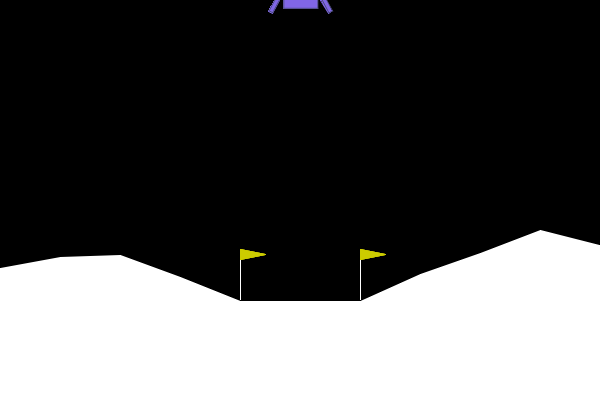

So, let's begin.

In [1]:
# !pip install -q torch
# !pip install -q gymnasium[box2d]

Import some staff...

In [2]:
import numpy as np
import torch as T
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import gymnasium as gym

Write a quick util for plotting the results

In [3]:
def plot_results(avg_scores, std_scores):
    # plot the results from a set of experiments
    n_episodes = len(avg_scores[0])
    n_experiments = len(avg_scores)

    avg_scores = np.array(avg_scores)
    avg_avg_scores = np.mean(avg_scores, axis=0)
    std_avg_scores = np.std(avg_scores, axis=0)

    upper_std_scores = avg_avg_scores + std_avg_scores
    lower_std_scores = avg_avg_scores - std_avg_scores
    x = range(1, n_episodes + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    ax[0].set_title("Score averaged over different experiments")
    ax[0].plot(x, avg_avg_scores, label=f'average score')
    ax[0].fill_between(x, upper_std_scores, lower_std_scores, 
                    where=(upper_std_scores > lower_std_scores), alpha=0.3)

    for i in range(n_experiments):
        avg_scores_numpy = np.array(avg_scores[i])
        std_scores_numpy = np.array(std_scores[i])
        upper = avg_scores_numpy + std_scores_numpy
        lower = avg_scores_numpy - std_scores_numpy
        ax[1].plot(x, avg_scores_numpy, label=f'Exp-{i}')
        ax[1].fill_between(x, upper, lower, where=(upper > lower), alpha=0.3)

    ax[1].set_xlabel('episode')
    ax[0].set_ylabel('score')
    ax[1].set_ylabel('score')
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()
    
def compare_results(data_dict):
    """
    Compare the results from different experiments
    :param: data_dict = {name1: [avg_scores1, std_scores1], 
                         name2: [avg_scores2, std_scores2],
                         ...
                         nameN: [avg_scoresN, std_scoresN],}
    """
    
    # plot the results from a set of experiments
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 6))
    ax.set_title("Comparison of different RL algorithms averaged score over a set of experiments")
    
    for item in data_dict:
        name = item
        avg_scores, std_scores = data_dict[name]
        
        n_episodes = len(avg_scores[0])
        n_experiments = len(avg_scores)

        avg_scores = np.array(avg_scores)
        avg_avg_scores = np.mean(avg_scores, axis=0)
        std_avg_scores = np.std(avg_scores, axis=0)

        upper_std_scores = avg_avg_scores + std_avg_scores
        lower_std_scores = avg_avg_scores - std_avg_scores
        x = range(1, n_episodes + 1)


        ax.plot(x, avg_avg_scores, label=f'{name} agent')
        ax.fill_between(x, upper_std_scores, lower_std_scores, 
                        where=(upper_std_scores > lower_std_scores), alpha=0.3)


    ax.set_ylabel('score')
    ax.legend()
    ax.grid()
    plt.show()
    
results_data_dict = {}

## AC for a discrete action space

In this notebook, we follow the implementation from Sutton & Barto book, you can see the details in the figure below (copied from the book).

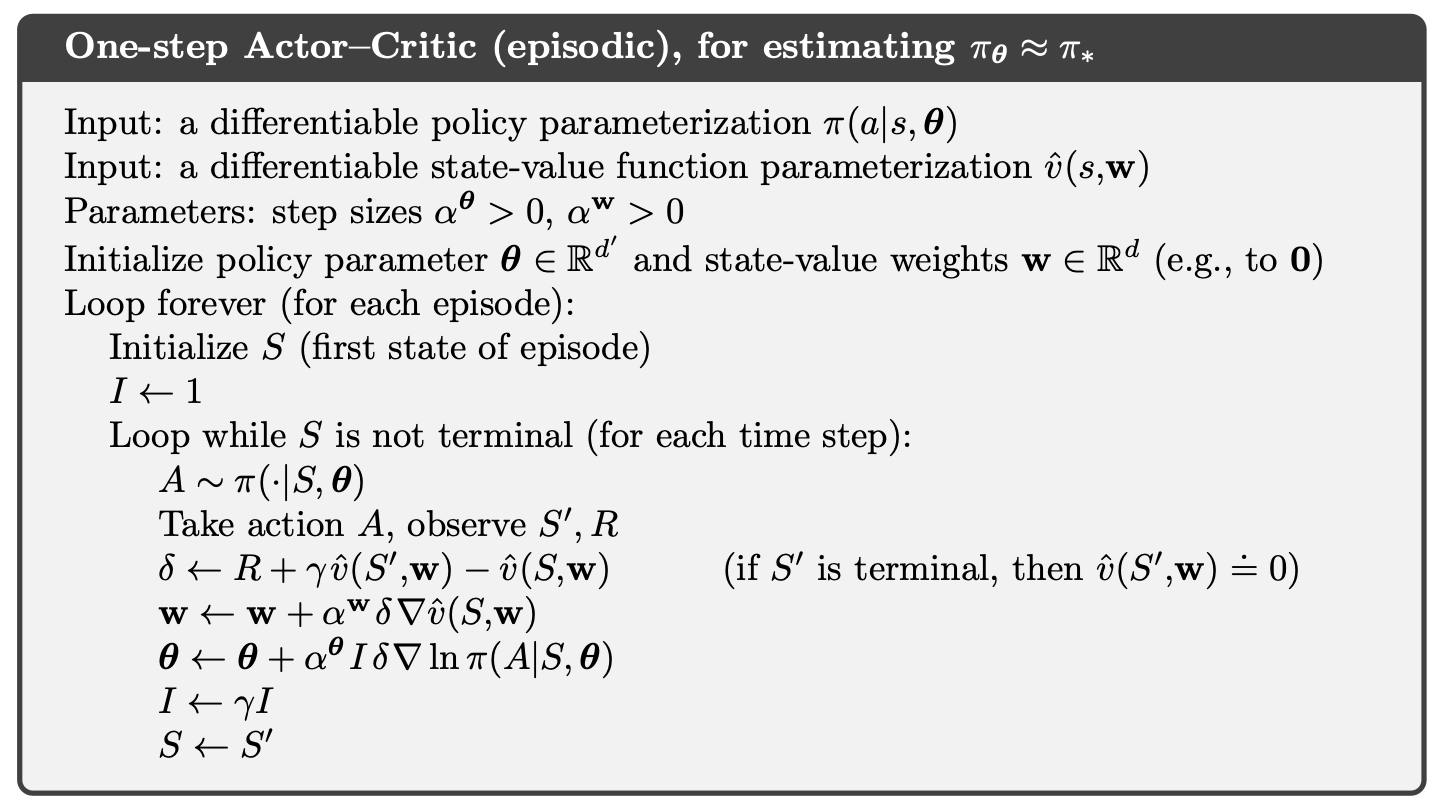


We first write the Actor (Policy) and Critic (Value) networks just as a simple feed-forward networks.

In [4]:
class ActorNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, lr):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=in_dim, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=out_dim)
        
        self.optimizer = T.optim.Adam(params=self.parameters(), lr=lr)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = T.softmax(x, dim=0)
        return x

class CriticNetwork(nn.Module):
    def __init__(self, in_dim, lr):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=in_dim, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=1)
        
        self.optimizer = T.optim.Adam(params=self.parameters(), lr=lr)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

Then, we write the Agent class, which has a `choose_action` and `learn` functions. A quick note, do not forget to reset the $I$ variable (responsible for the discounting) after each episode back to $I=1$.

In [5]:
class ActorCriticAgent:
    def __init__(self, in_dim, out_dim, actor_lr, critic_lr, gamma):
        self.gamma = gamma
        self.I = None
        
        # init actor
        self.actor = ActorNetwork(in_dim=in_dim, out_dim=out_dim, lr=actor_lr)
        
        # init critic
        self.critic = CriticNetwork(in_dim=in_dim, lr=critic_lr)
    
    def reset(self):
        self.I = 1.
        
    def choose_action(self, observation):
        observation_ = T.Tensor(observation).float().to(self.actor.device)
        probs = self.actor(observation_)
        m = T.distributions.Categorical(probs=probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
    
    def learn(self, observation, reward, observation_, log_prob, terminated):
        # compute values
        value = self.critic(T.from_numpy(observation).float().to(self.critic.device))
        if terminated:
            value_ = T.tensor([0.]).to(self.actor.device)
        else:
            value_ = self.critic(T.from_numpy(observation_).float().to(self.critic.device))
        
        # compute delta
        target = T.Tensor([reward]).float().to(self.critic.device) + self.gamma * value_
        delta = (target - value).to(self.actor.device)
        
        # train critic
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, value)
        critic_loss.backward()
        self.critic.optimizer.step()
        
        # train actor
        self.actor.optimizer.zero_grad()
        actor_loss = -self.I * delta.detach() * T.Tensor(log_prob).float().to(self.actor.device)
        actor_loss.backward()
        self.actor.optimizer.step()
        
        # discount I
        self.I = self.I * self.gamma
        

Let's run a few experiments.

In [6]:
# initialize environment
env = gym.make(
    "LunarLander-v2",
    continuous=False,
    gravity=-10.0,
    enable_wind=False,
    wind_power=0.0,
    turbulence_power=0.0)


# define hyperparameters
MAX_STEPS = 250
N_EPISODES = 800
EXPERIMENTS = 3
OBSERVATION_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.n
LR_POLICY = 1e-4
LR_VALUE = 1e-4
GAMMA = 0.99

scores = []
avg_scores = []
std_scores = []


# run experiments for all seeds
for i, experiment in enumerate(range(EXPERIMENTS)):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    
    # initialize the agent
    agent = ActorCriticAgent(in_dim=OBSERVATION_DIM, 
                             out_dim=ACTION_DIM, 
                             actor_lr=LR_POLICY, 
                             critic_lr=LR_VALUE, 
                             gamma=GAMMA)

    
    # loop for n episodes
    for episode in range(N_EPISODES):
        observation, info = env.reset()
        agent.reset()
        done = False
        score = 0
        steps = 0
        
        # single episode loop
        while not done:
            steps += 1  
            action, log_prob = agent.choose_action(observation)
            next_observation, reward, terminated, truncated, info = env.step(action)
            score += reward
            
            # train the agent
            agent.learn(observation, reward, next_observation, log_prob, terminated)
            observation = next_observation
            
            # check for termination
            if terminated or truncated or steps == MAX_STEPS:
                done = True
                scores[i].append(score)
                avg_scores[i].append(np.mean(scores[i][-100:]))
                std_scores[i].append(np.std(scores[i][-100:]))
            
            
        print(f'| Experiment: {experiment + 1:4} | Episode: {episode:4} | Score: {np.round(score, 2):2.3f} |' + 
              f' Avg score: {np.round(avg_scores[i][-1], 2):2.3f} |')
    env.close()

| Experiment:    1 | Episode:    0 | Score: -117.120 | Avg score: -117.120 |
| Experiment:    1 | Episode:    1 | Score: -75.610 | Avg score: -96.360 |
| Experiment:    1 | Episode:    2 | Score: -282.170 | Avg score: -158.300 |
| Experiment:    1 | Episode:    3 | Score: -392.870 | Avg score: -216.940 |
| Experiment:    1 | Episode:    4 | Score: -69.140 | Avg score: -187.380 |
| Experiment:    1 | Episode:    5 | Score: -88.830 | Avg score: -170.960 |
| Experiment:    1 | Episode:    6 | Score: -153.090 | Avg score: -168.400 |
| Experiment:    1 | Episode:    7 | Score: -469.260 | Avg score: -206.010 |
| Experiment:    1 | Episode:    8 | Score: -333.510 | Avg score: -220.180 |
| Experiment:    1 | Episode:    9 | Score: -294.070 | Avg score: -227.570 |
| Experiment:    1 | Episode:   10 | Score: -480.970 | Avg score: -250.600 |
| Experiment:    1 | Episode:   11 | Score: -325.250 | Avg score: -256.820 |
| Experiment:    1 | Episode:   12 | Score: -209.100 | Avg score: -253.150 |
| E

| Experiment:    1 | Episode:  108 | Score: -58.650 | Avg score: -119.490 |
| Experiment:    1 | Episode:  109 | Score: 24.820 | Avg score: -116.300 |
| Experiment:    1 | Episode:  110 | Score: 8.610 | Avg score: -111.410 |
| Experiment:    1 | Episode:  111 | Score: -77.550 | Avg score: -108.930 |
| Experiment:    1 | Episode:  112 | Score: 23.570 | Avg score: -106.600 |
| Experiment:    1 | Episode:  113 | Score: 15.760 | Avg score: -105.180 |
| Experiment:    1 | Episode:  114 | Score: -54.730 | Avg score: -103.400 |
| Experiment:    1 | Episode:  115 | Score: -78.160 | Avg score: -101.020 |
| Experiment:    1 | Episode:  116 | Score: -32.390 | Avg score: -99.480 |
| Experiment:    1 | Episode:  117 | Score: -37.750 | Avg score: -97.390 |
| Experiment:    1 | Episode:  118 | Score: -36.590 | Avg score: -97.200 |
| Experiment:    1 | Episode:  119 | Score: -61.160 | Avg score: -94.550 |
| Experiment:    1 | Episode:  120 | Score: 10.330 | Avg score: -91.640 |
| Experiment:    1 | Ep

| Experiment:    1 | Episode:  218 | Score: 5.360 | Avg score: -14.580 |
| Experiment:    1 | Episode:  219 | Score: 140.240 | Avg score: -12.570 |
| Experiment:    1 | Episode:  220 | Score: -158.650 | Avg score: -14.260 |
| Experiment:    1 | Episode:  221 | Score: -72.130 | Avg score: -15.210 |
| Experiment:    1 | Episode:  222 | Score: -32.100 | Avg score: -14.910 |
| Experiment:    1 | Episode:  223 | Score: 49.650 | Avg score: -14.050 |
| Experiment:    1 | Episode:  224 | Score: -22.870 | Avg score: -13.640 |
| Experiment:    1 | Episode:  225 | Score: -15.190 | Avg score: -14.000 |
| Experiment:    1 | Episode:  226 | Score: 5.600 | Avg score: -14.190 |
| Experiment:    1 | Episode:  227 | Score: 22.500 | Avg score: -13.260 |
| Experiment:    1 | Episode:  228 | Score: 126.720 | Avg score: -11.950 |
| Experiment:    1 | Episode:  229 | Score: -24.180 | Avg score: -13.300 |
| Experiment:    1 | Episode:  230 | Score: -40.590 | Avg score: -12.940 |
| Experiment:    1 | Episode: 

| Experiment:    1 | Episode:  330 | Score: 35.610 | Avg score: -10.010 |
| Experiment:    1 | Episode:  331 | Score: 15.520 | Avg score: -9.920 |
| Experiment:    1 | Episode:  332 | Score: 12.290 | Avg score: -9.810 |
| Experiment:    1 | Episode:  333 | Score: -36.880 | Avg score: -11.150 |
| Experiment:    1 | Episode:  334 | Score: -13.540 | Avg score: -11.690 |
| Experiment:    1 | Episode:  335 | Score: 156.730 | Avg score: -10.060 |
| Experiment:    1 | Episode:  336 | Score: 27.490 | Avg score: -9.530 |
| Experiment:    1 | Episode:  337 | Score: -12.980 | Avg score: -9.800 |
| Experiment:    1 | Episode:  338 | Score: 55.200 | Avg score: -9.070 |
| Experiment:    1 | Episode:  339 | Score: 21.960 | Avg score: -9.020 |
| Experiment:    1 | Episode:  340 | Score: 68.920 | Avg score: -6.560 |
| Experiment:    1 | Episode:  341 | Score: -19.000 | Avg score: -7.110 |
| Experiment:    1 | Episode:  342 | Score: -27.820 | Avg score: -7.250 |
| Experiment:    1 | Episode:  343 | Scor

| Experiment:    1 | Episode:  442 | Score: 158.190 | Avg score: 16.320 |
| Experiment:    1 | Episode:  443 | Score: 27.660 | Avg score: 17.710 |
| Experiment:    1 | Episode:  444 | Score: -4.350 | Avg score: 17.300 |
| Experiment:    1 | Episode:  445 | Score: 69.710 | Avg score: 17.700 |
| Experiment:    1 | Episode:  446 | Score: 34.580 | Avg score: 18.180 |
| Experiment:    1 | Episode:  447 | Score: 57.020 | Avg score: 19.390 |
| Experiment:    1 | Episode:  448 | Score: 3.440 | Avg score: 19.900 |
| Experiment:    1 | Episode:  449 | Score: 33.070 | Avg score: 20.130 |
| Experiment:    1 | Episode:  450 | Score: 79.100 | Avg score: 21.420 |
| Experiment:    1 | Episode:  451 | Score: 44.050 | Avg score: 22.160 |
| Experiment:    1 | Episode:  452 | Score: 16.620 | Avg score: 22.690 |
| Experiment:    1 | Episode:  453 | Score: 25.990 | Avg score: 22.700 |
| Experiment:    1 | Episode:  454 | Score: 32.970 | Avg score: 22.940 |
| Experiment:    1 | Episode:  455 | Score: 4.630 |

| Experiment:    1 | Episode:  554 | Score: 136.550 | Avg score: 57.480 |
| Experiment:    1 | Episode:  555 | Score: 203.540 | Avg score: 59.470 |
| Experiment:    1 | Episode:  556 | Score: 2.830 | Avg score: 59.090 |
| Experiment:    1 | Episode:  557 | Score: 94.990 | Avg score: 59.310 |
| Experiment:    1 | Episode:  558 | Score: 37.910 | Avg score: 59.050 |
| Experiment:    1 | Episode:  559 | Score: 189.750 | Avg score: 60.300 |
| Experiment:    1 | Episode:  560 | Score: 132.800 | Avg score: 63.090 |
| Experiment:    1 | Episode:  561 | Score: 50.590 | Avg score: 61.970 |
| Experiment:    1 | Episode:  562 | Score: 60.070 | Avg score: 62.820 |
| Experiment:    1 | Episode:  563 | Score: 19.990 | Avg score: 62.530 |
| Experiment:    1 | Episode:  564 | Score: 28.560 | Avg score: 61.040 |
| Experiment:    1 | Episode:  565 | Score: 24.250 | Avg score: 60.730 |
| Experiment:    1 | Episode:  566 | Score: 170.950 | Avg score: 62.700 |
| Experiment:    1 | Episode:  567 | Score: -13

| Experiment:    1 | Episode:  666 | Score: -16.350 | Avg score: 51.910 |
| Experiment:    1 | Episode:  667 | Score: -173.410 | Avg score: 50.300 |
| Experiment:    1 | Episode:  668 | Score: 1.130 | Avg score: 49.830 |
| Experiment:    1 | Episode:  669 | Score: 38.400 | Avg score: 50.460 |
| Experiment:    1 | Episode:  670 | Score: -17.150 | Avg score: 49.960 |
| Experiment:    1 | Episode:  671 | Score: 21.900 | Avg score: 50.210 |
| Experiment:    1 | Episode:  672 | Score: 116.960 | Avg score: 51.300 |
| Experiment:    1 | Episode:  673 | Score: -16.160 | Avg score: 51.230 |
| Experiment:    1 | Episode:  674 | Score: 98.330 | Avg score: 50.520 |
| Experiment:    1 | Episode:  675 | Score: 69.710 | Avg score: 49.700 |
| Experiment:    1 | Episode:  676 | Score: 27.990 | Avg score: 50.100 |
| Experiment:    1 | Episode:  677 | Score: 121.860 | Avg score: 49.550 |
| Experiment:    1 | Episode:  678 | Score: 133.210 | Avg score: 50.980 |
| Experiment:    1 | Episode:  679 | Score: 

| Experiment:    1 | Episode:  778 | Score: -30.210 | Avg score: 68.850 |
| Experiment:    1 | Episode:  779 | Score: -11.710 | Avg score: 68.520 |
| Experiment:    1 | Episode:  780 | Score: 57.620 | Avg score: 68.230 |
| Experiment:    1 | Episode:  781 | Score: -6.330 | Avg score: 66.340 |
| Experiment:    1 | Episode:  782 | Score: 37.140 | Avg score: 65.260 |
| Experiment:    1 | Episode:  783 | Score: 68.190 | Avg score: 64.850 |
| Experiment:    1 | Episode:  784 | Score: 83.830 | Avg score: 64.370 |
| Experiment:    1 | Episode:  785 | Score: 33.750 | Avg score: 63.010 |
| Experiment:    1 | Episode:  786 | Score: 100.560 | Avg score: 63.870 |
| Experiment:    1 | Episode:  787 | Score: 53.170 | Avg score: 64.120 |
| Experiment:    1 | Episode:  788 | Score: 13.820 | Avg score: 64.070 |
| Experiment:    1 | Episode:  789 | Score: 22.260 | Avg score: 64.090 |
| Experiment:    1 | Episode:  790 | Score: 55.770 | Avg score: 63.130 |
| Experiment:    1 | Episode:  791 | Score: 172.

| Experiment:    2 | Episode:   87 | Score: -10.180 | Avg score: -141.880 |
| Experiment:    2 | Episode:   88 | Score: -48.260 | Avg score: -140.830 |
| Experiment:    2 | Episode:   89 | Score: -54.870 | Avg score: -139.880 |
| Experiment:    2 | Episode:   90 | Score: -92.100 | Avg score: -139.350 |
| Experiment:    2 | Episode:   91 | Score: -106.330 | Avg score: -138.990 |
| Experiment:    2 | Episode:   92 | Score: -24.410 | Avg score: -137.760 |
| Experiment:    2 | Episode:   93 | Score: 14.570 | Avg score: -136.140 |
| Experiment:    2 | Episode:   94 | Score: 35.670 | Avg score: -134.330 |
| Experiment:    2 | Episode:   95 | Score: 28.920 | Avg score: -132.630 |
| Experiment:    2 | Episode:   96 | Score: 49.160 | Avg score: -130.760 |
| Experiment:    2 | Episode:   97 | Score: -16.770 | Avg score: -129.590 |
| Experiment:    2 | Episode:   98 | Score: 28.680 | Avg score: -127.990 |
| Experiment:    2 | Episode:   99 | Score: 18.710 | Avg score: -126.530 |
| Experiment:    

| Experiment:    2 | Episode:  197 | Score: -12.010 | Avg score: -26.030 |
| Experiment:    2 | Episode:  198 | Score: 2.910 | Avg score: -26.280 |
| Experiment:    2 | Episode:  199 | Score: -9.600 | Avg score: -26.570 |
| Experiment:    2 | Episode:  200 | Score: 8.070 | Avg score: -26.880 |
| Experiment:    2 | Episode:  201 | Score: -28.820 | Avg score: -26.760 |
| Experiment:    2 | Episode:  202 | Score: 79.480 | Avg score: -25.570 |
| Experiment:    2 | Episode:  203 | Score: -7.010 | Avg score: -25.300 |
| Experiment:    2 | Episode:  204 | Score: -53.650 | Avg score: -25.530 |
| Experiment:    2 | Episode:  205 | Score: -19.410 | Avg score: -23.530 |
| Experiment:    2 | Episode:  206 | Score: 21.090 | Avg score: -21.000 |
| Experiment:    2 | Episode:  207 | Score: -21.580 | Avg score: -21.460 |
| Experiment:    2 | Episode:  208 | Score: 43.080 | Avg score: -20.990 |
| Experiment:    2 | Episode:  209 | Score: 14.260 | Avg score: -20.060 |
| Experiment:    2 | Episode:  210 

| Experiment:    2 | Episode:  308 | Score: 75.130 | Avg score: -12.330 |
| Experiment:    2 | Episode:  309 | Score: -67.780 | Avg score: -13.150 |
| Experiment:    2 | Episode:  310 | Score: 44.540 | Avg score: -12.580 |
| Experiment:    2 | Episode:  311 | Score: -51.970 | Avg score: -13.250 |
| Experiment:    2 | Episode:  312 | Score: 9.820 | Avg score: -12.570 |
| Experiment:    2 | Episode:  313 | Score: -162.490 | Avg score: -14.000 |
| Experiment:    2 | Episode:  314 | Score: -22.590 | Avg score: -14.580 |
| Experiment:    2 | Episode:  315 | Score: -40.340 | Avg score: -15.080 |
| Experiment:    2 | Episode:  316 | Score: 15.000 | Avg score: -15.070 |
| Experiment:    2 | Episode:  317 | Score: -18.440 | Avg score: -14.790 |
| Experiment:    2 | Episode:  318 | Score: -51.140 | Avg score: -14.900 |
| Experiment:    2 | Episode:  319 | Score: 5.700 | Avg score: -14.190 |
| Experiment:    2 | Episode:  320 | Score: -5.460 | Avg score: -14.280 |
| Experiment:    2 | Episode:  3

| Experiment:    2 | Episode:  420 | Score: 50.030 | Avg score: 23.280 |
| Experiment:    2 | Episode:  421 | Score: 22.520 | Avg score: 23.890 |
| Experiment:    2 | Episode:  422 | Score: -32.680 | Avg score: 23.500 |
| Experiment:    2 | Episode:  423 | Score: 10.840 | Avg score: 24.040 |
| Experiment:    2 | Episode:  424 | Score: -41.960 | Avg score: 23.010 |
| Experiment:    2 | Episode:  425 | Score: 47.310 | Avg score: 23.760 |
| Experiment:    2 | Episode:  426 | Score: 51.350 | Avg score: 24.120 |
| Experiment:    2 | Episode:  427 | Score: -14.430 | Avg score: 23.810 |
| Experiment:    2 | Episode:  428 | Score: 11.850 | Avg score: 23.970 |
| Experiment:    2 | Episode:  429 | Score: 4.990 | Avg score: 24.480 |
| Experiment:    2 | Episode:  430 | Score: -37.080 | Avg score: 23.770 |
| Experiment:    2 | Episode:  431 | Score: 167.910 | Avg score: 25.400 |
| Experiment:    2 | Episode:  432 | Score: 45.620 | Avg score: 24.410 |
| Experiment:    2 | Episode:  433 | Score: 123

| Experiment:    2 | Episode:  532 | Score: -23.440 | Avg score: 43.930 |
| Experiment:    2 | Episode:  533 | Score: -19.640 | Avg score: 42.490 |
| Experiment:    2 | Episode:  534 | Score: -2.650 | Avg score: 43.840 |
| Experiment:    2 | Episode:  535 | Score: 194.630 | Avg score: 45.380 |
| Experiment:    2 | Episode:  536 | Score: 7.390 | Avg score: 45.350 |
| Experiment:    2 | Episode:  537 | Score: -10.070 | Avg score: 43.530 |
| Experiment:    2 | Episode:  538 | Score: 36.510 | Avg score: 43.500 |
| Experiment:    2 | Episode:  539 | Score: 148.360 | Avg score: 46.550 |
| Experiment:    2 | Episode:  540 | Score: 57.700 | Avg score: 47.170 |
| Experiment:    2 | Episode:  541 | Score: 176.630 | Avg score: 48.290 |
| Experiment:    2 | Episode:  542 | Score: 86.920 | Avg score: 49.480 |
| Experiment:    2 | Episode:  543 | Score: 8.460 | Avg score: 48.710 |
| Experiment:    2 | Episode:  544 | Score: 66.650 | Avg score: 49.300 |
| Experiment:    2 | Episode:  545 | Score: 151

| Experiment:    2 | Episode:  644 | Score: 49.330 | Avg score: 50.290 |
| Experiment:    2 | Episode:  645 | Score: 43.780 | Avg score: 49.210 |
| Experiment:    2 | Episode:  646 | Score: 135.180 | Avg score: 50.300 |
| Experiment:    2 | Episode:  647 | Score: 91.930 | Avg score: 50.360 |
| Experiment:    2 | Episode:  648 | Score: 105.290 | Avg score: 50.550 |
| Experiment:    2 | Episode:  649 | Score: 124.930 | Avg score: 51.390 |
| Experiment:    2 | Episode:  650 | Score: 36.010 | Avg score: 50.890 |
| Experiment:    2 | Episode:  651 | Score: 35.190 | Avg score: 51.000 |
| Experiment:    2 | Episode:  652 | Score: 175.590 | Avg score: 52.280 |
| Experiment:    2 | Episode:  653 | Score: -7.980 | Avg score: 51.630 |
| Experiment:    2 | Episode:  654 | Score: 96.730 | Avg score: 54.090 |
| Experiment:    2 | Episode:  655 | Score: 15.730 | Avg score: 52.660 |
| Experiment:    2 | Episode:  656 | Score: 15.290 | Avg score: 51.070 |
| Experiment:    2 | Episode:  657 | Score: -35

| Experiment:    2 | Episode:  756 | Score: 201.950 | Avg score: 64.310 |
| Experiment:    2 | Episode:  757 | Score: -14.350 | Avg score: 64.520 |
| Experiment:    2 | Episode:  758 | Score: 1.760 | Avg score: 63.030 |
| Experiment:    2 | Episode:  759 | Score: -50.610 | Avg score: 61.950 |
| Experiment:    2 | Episode:  760 | Score: 100.600 | Avg score: 62.520 |
| Experiment:    2 | Episode:  761 | Score: -7.680 | Avg score: 61.530 |
| Experiment:    2 | Episode:  762 | Score: 41.260 | Avg score: 61.760 |
| Experiment:    2 | Episode:  763 | Score: 46.070 | Avg score: 60.520 |
| Experiment:    2 | Episode:  764 | Score: 25.670 | Avg score: 59.460 |
| Experiment:    2 | Episode:  765 | Score: 8.830 | Avg score: 58.290 |
| Experiment:    2 | Episode:  766 | Score: 143.520 | Avg score: 59.050 |
| Experiment:    2 | Episode:  767 | Score: 69.300 | Avg score: 58.110 |
| Experiment:    2 | Episode:  768 | Score: 44.920 | Avg score: 56.920 |
| Experiment:    2 | Episode:  769 | Score: 41.7

| Experiment:    3 | Episode:   66 | Score: 113.320 | Avg score: -176.870 |
| Experiment:    3 | Episode:   67 | Score: -224.400 | Avg score: -177.570 |
| Experiment:    3 | Episode:   68 | Score: -11.080 | Avg score: -175.150 |
| Experiment:    3 | Episode:   69 | Score: -94.820 | Avg score: -174.010 |
| Experiment:    3 | Episode:   70 | Score: -51.340 | Avg score: -172.280 |
| Experiment:    3 | Episode:   71 | Score: -105.330 | Avg score: -171.350 |
| Experiment:    3 | Episode:   72 | Score: -94.350 | Avg score: -170.290 |
| Experiment:    3 | Episode:   73 | Score: -79.210 | Avg score: -169.060 |
| Experiment:    3 | Episode:   74 | Score: -208.800 | Avg score: -169.590 |
| Experiment:    3 | Episode:   75 | Score: -21.380 | Avg score: -167.640 |
| Experiment:    3 | Episode:   76 | Score: 63.340 | Avg score: -164.640 |
| Experiment:    3 | Episode:   77 | Score: -305.900 | Avg score: -166.450 |
| Experiment:    3 | Episode:   78 | Score: 12.930 | Avg score: -164.180 |
| Experime

| Experiment:    3 | Episode:  175 | Score: 27.610 | Avg score: -24.030 |
| Experiment:    3 | Episode:  176 | Score: -11.650 | Avg score: -24.780 |
| Experiment:    3 | Episode:  177 | Score: 146.460 | Avg score: -20.250 |
| Experiment:    3 | Episode:  178 | Score: -13.050 | Avg score: -20.510 |
| Experiment:    3 | Episode:  179 | Score: -34.560 | Avg score: -20.740 |
| Experiment:    3 | Episode:  180 | Score: -40.140 | Avg score: -21.780 |
| Experiment:    3 | Episode:  181 | Score: -42.890 | Avg score: -20.320 |
| Experiment:    3 | Episode:  182 | Score: -57.240 | Avg score: -18.980 |
| Experiment:    3 | Episode:  183 | Score: -60.990 | Avg score: -19.120 |
| Experiment:    3 | Episode:  184 | Score: 10.970 | Avg score: -18.930 |
| Experiment:    3 | Episode:  185 | Score: -12.230 | Avg score: -19.080 |
| Experiment:    3 | Episode:  186 | Score: 11.290 | Avg score: -19.300 |
| Experiment:    3 | Episode:  187 | Score: 27.910 | Avg score: -18.180 |
| Experiment:    3 | Episode:

| Experiment:    3 | Episode:  287 | Score: -6.740 | Avg score: -0.960 |
| Experiment:    3 | Episode:  288 | Score: 19.530 | Avg score: -0.540 |
| Experiment:    3 | Episode:  289 | Score: -6.720 | Avg score: -0.850 |
| Experiment:    3 | Episode:  290 | Score: -139.670 | Avg score: -2.340 |
| Experiment:    3 | Episode:  291 | Score: 165.910 | Avg score: -0.250 |
| Experiment:    3 | Episode:  292 | Score: 4.480 | Avg score: 0.260 |
| Experiment:    3 | Episode:  293 | Score: 86.990 | Avg score: 1.290 |
| Experiment:    3 | Episode:  294 | Score: -54.230 | Avg score: 0.260 |
| Experiment:    3 | Episode:  295 | Score: 154.030 | Avg score: 1.660 |
| Experiment:    3 | Episode:  296 | Score: -44.150 | Avg score: 1.560 |
| Experiment:    3 | Episode:  297 | Score: -70.990 | Avg score: 0.750 |
| Experiment:    3 | Episode:  298 | Score: -24.880 | Avg score: -0.310 |
| Experiment:    3 | Episode:  299 | Score: -18.470 | Avg score: -0.340 |
| Experiment:    3 | Episode:  300 | Score: -166.

| Experiment:    3 | Episode:  400 | Score: 73.420 | Avg score: 16.320 |
| Experiment:    3 | Episode:  401 | Score: 14.530 | Avg score: 16.190 |
| Experiment:    3 | Episode:  402 | Score: 7.890 | Avg score: 16.390 |
| Experiment:    3 | Episode:  403 | Score: 145.390 | Avg score: 17.360 |
| Experiment:    3 | Episode:  404 | Score: 27.620 | Avg score: 18.190 |
| Experiment:    3 | Episode:  405 | Score: 17.800 | Avg score: 18.310 |
| Experiment:    3 | Episode:  406 | Score: 21.060 | Avg score: 18.260 |
| Experiment:    3 | Episode:  407 | Score: 2.970 | Avg score: 18.460 |
| Experiment:    3 | Episode:  408 | Score: 52.360 | Avg score: 19.140 |
| Experiment:    3 | Episode:  409 | Score: 61.100 | Avg score: 19.920 |
| Experiment:    3 | Episode:  410 | Score: 175.560 | Avg score: 21.310 |
| Experiment:    3 | Episode:  411 | Score: -5.030 | Avg score: 20.040 |
| Experiment:    3 | Episode:  412 | Score: -61.370 | Avg score: 19.130 |
| Experiment:    3 | Episode:  413 | Score: 152.35

| Experiment:    3 | Episode:  512 | Score: 137.550 | Avg score: 53.770 |
| Experiment:    3 | Episode:  513 | Score: 172.790 | Avg score: 53.980 |
| Experiment:    3 | Episode:  514 | Score: 179.080 | Avg score: 55.860 |
| Experiment:    3 | Episode:  515 | Score: -77.620 | Avg score: 54.770 |
| Experiment:    3 | Episode:  516 | Score: 108.470 | Avg score: 55.710 |
| Experiment:    3 | Episode:  517 | Score: 24.650 | Avg score: 55.840 |
| Experiment:    3 | Episode:  518 | Score: 36.440 | Avg score: 55.820 |
| Experiment:    3 | Episode:  519 | Score: 167.820 | Avg score: 56.990 |
| Experiment:    3 | Episode:  520 | Score: 10.410 | Avg score: 56.610 |
| Experiment:    3 | Episode:  521 | Score: 137.980 | Avg score: 56.750 |
| Experiment:    3 | Episode:  522 | Score: 65.020 | Avg score: 57.300 |
| Experiment:    3 | Episode:  523 | Score: 39.230 | Avg score: 57.500 |
| Experiment:    3 | Episode:  524 | Score: 66.010 | Avg score: 57.110 |
| Experiment:    3 | Episode:  525 | Score: 

| Experiment:    3 | Episode:  624 | Score: 44.020 | Avg score: 43.450 |
| Experiment:    3 | Episode:  625 | Score: 38.420 | Avg score: 43.010 |
| Experiment:    3 | Episode:  626 | Score: -6.140 | Avg score: 42.220 |
| Experiment:    3 | Episode:  627 | Score: -47.610 | Avg score: 41.600 |
| Experiment:    3 | Episode:  628 | Score: 163.650 | Avg score: 43.030 |
| Experiment:    3 | Episode:  629 | Score: -7.960 | Avg score: 42.390 |
| Experiment:    3 | Episode:  630 | Score: 13.410 | Avg score: 42.410 |
| Experiment:    3 | Episode:  631 | Score: 175.240 | Avg score: 42.750 |
| Experiment:    3 | Episode:  632 | Score: 172.300 | Avg score: 43.570 |
| Experiment:    3 | Episode:  633 | Score: -19.860 | Avg score: 43.270 |
| Experiment:    3 | Episode:  634 | Score: 20.020 | Avg score: 43.640 |
| Experiment:    3 | Episode:  635 | Score: 2.750 | Avg score: 42.940 |
| Experiment:    3 | Episode:  636 | Score: 59.960 | Avg score: 42.920 |
| Experiment:    3 | Episode:  637 | Score: 59.

| Experiment:    3 | Episode:  736 | Score: 10.300 | Avg score: 64.370 |
| Experiment:    3 | Episode:  737 | Score: 38.990 | Avg score: 64.160 |
| Experiment:    3 | Episode:  738 | Score: 19.250 | Avg score: 63.310 |
| Experiment:    3 | Episode:  739 | Score: 20.280 | Avg score: 63.170 |
| Experiment:    3 | Episode:  740 | Score: -16.750 | Avg score: 62.660 |
| Experiment:    3 | Episode:  741 | Score: 79.130 | Avg score: 62.290 |
| Experiment:    3 | Episode:  742 | Score: 9.600 | Avg score: 63.910 |
| Experiment:    3 | Episode:  743 | Score: -13.360 | Avg score: 61.970 |
| Experiment:    3 | Episode:  744 | Score: 8.890 | Avg score: 60.750 |
| Experiment:    3 | Episode:  745 | Score: 171.790 | Avg score: 62.430 |
| Experiment:    3 | Episode:  746 | Score: 51.490 | Avg score: 62.700 |
| Experiment:    3 | Episode:  747 | Score: 32.430 | Avg score: 62.580 |
| Experiment:    3 | Episode:  748 | Score: 68.370 | Avg score: 62.160 |
| Experiment:    3 | Episode:  749 | Score: 117.59

In [7]:
results_data_dict["Actor_Critic_discrete"] = [avg_scores, std_scores]

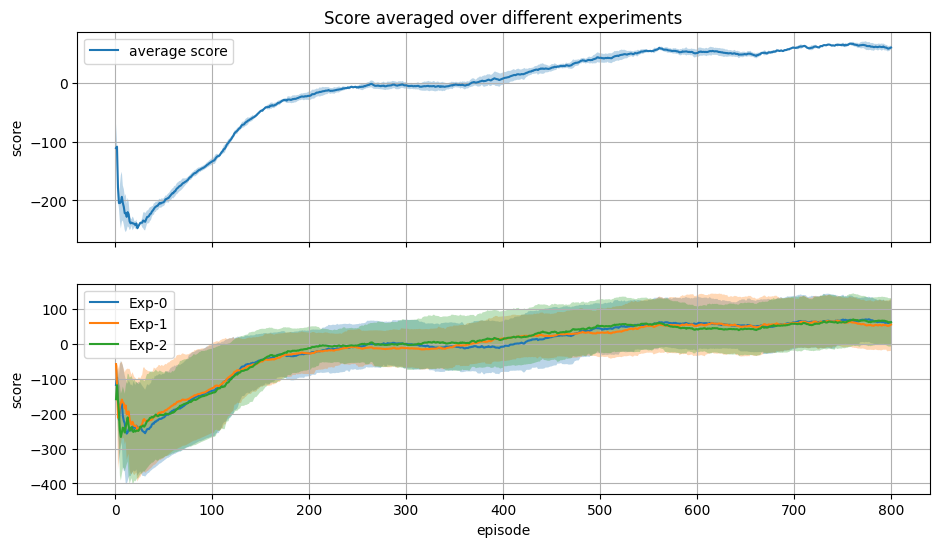

In [8]:
plot_results(avg_scores, std_scores)

The Lunar Lander environment can be considered solved if one reaches at least 200 points. We see from the results above that the algorithm was able to converge to a Q-function which translates to a policy with a mean score of around 80. This is nice, although not optimal. In addition, I didn't put a lot of effort in tuning the model's hyperparameters.

## AC for a continuous action space
In the continuous action space case, the Actor-Critic algorithm is the same as before with a small change. The Actor network now outputs the two moments, $\mu, \sigma$, of a Gaussian distribution (both in the action space dimension), which are later used for creating the distribution, and sample the action and its probability from it. For more details, you should check out Chapter 13.7 from Sutton & Barto book on continuous action spaces.

In [9]:
class ActorNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, lr):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=in_dim, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.mu = nn.Linear(in_features=256, out_features=out_dim)
        self.sigma = nn.Linear(in_features=256, out_features=out_dim)
         
        self.optimizer = T.optim.Adam(params=self.parameters(), lr=lr)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        mu = self.mu(x)
        sigma = T.exp(self.sigma(x))
        return mu, sigma

class CriticNetwork(nn.Module):
    def __init__(self, in_dim, lr):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=in_dim, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=1)
        
        self.optimizer = T.optim.Adam(params=self.parameters(), lr=lr)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

The agent implementation's has also a few tweaks from the discrete case, mainly in the `choose_action` function. 

In [10]:
class ActorCriticAgent:
    def __init__(self, in_dim, out_dim, actor_lr, critic_lr, gamma):
        self.gamma = gamma
        self.I = None
        
        # init actor
        self.actor = ActorNetwork(in_dim=in_dim, out_dim=out_dim, lr=actor_lr)
        
        # init critic
        self.critic = CriticNetwork(in_dim=in_dim, lr=critic_lr)
    
    def reset(self):
        self.I = 1.
        
    def choose_action(self, observation):
        # send observation to device
        observation_ = T.Tensor(observation).float().to(self.actor.device)
        
        # feed-forward through the network to extract the policy distribution's moments
        mu, sigma = self.actor(observation_)
        
        # generate the distribution
        m = T.distributions.Normal(loc=mu, scale=sigma)
        
        # sample it
        action = m.sample()
        return T.tanh(action).detach().cpu().numpy(), m.log_prob(action)
    
    def learn(self, observation, reward, observation_, log_prob, terminated):
        # compute values
        value = self.critic(T.from_numpy(observation).float().to(self.critic.device))
        if terminated:
            value_ = T.Tensor([0.]).to(self.critic.device)
        else:
            value_ = self.critic(T.from_numpy(observation_).float().to(self.critic.device))
        
        # compute delta
        target = T.Tensor([reward]).float().to(self.critic.device) + self.gamma * value_
        delta = (target - value).to(self.actor.device)
        
        # train critic
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, value)
        critic_loss.backward()
        self.critic.optimizer.step()
        
        # train actor 
        self.actor.optimizer.zero_grad()
        actor_loss = -self.I * T.sum(delta.detach() * T.Tensor(log_prob).float().to(self.actor.device))
        actor_loss.backward()
        self.actor.optimizer.step()
        
        # discount I
        self.I = self.I * self.gamma
        

And, let's run it

In [12]:
# initialize environment
env = gym.make(
    "LunarLander-v2",
    continuous=True,
    gravity=-10.0,
    enable_wind=False,
    wind_power=0.0,
    turbulence_power=0.0)


# define hyperparameters
MAX_STEPS = 250
N_EPISODES = 800
EXPERIMENTS = 3
OBSERVATION_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.shape[0]
LR_POLICY = 5e-5
LR_VALUE = 5e-4
GAMMA = 0.99

scores = []
avg_scores = []
std_scores = []


# run experiments for all seeds
for i, experiment in enumerate(range(EXPERIMENTS)):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    
    # initialize the agent
    agent = ActorCriticAgent(in_dim=OBSERVATION_DIM, 
                             out_dim=ACTION_DIM, 
                             actor_lr=LR_POLICY, 
                             critic_lr=LR_VALUE, 
                             gamma=GAMMA)

    
    # loop for n episodes
    for episode in range(N_EPISODES):
        observation, info = env.reset()
        agent.reset()
        done = False
        score = 0
        steps = 0
        
        # single episode loop
        while not done:
            steps += 1  
            action, log_prob = agent.choose_action(observation)
            next_observation, reward, terminated, truncated, info = env.step(action)
            score += reward
            
            # train
            agent.learn(observation, reward, next_observation, log_prob, terminated)
            observation = next_observation
            
            # check for termination
            if terminated or truncated or steps == MAX_STEPS:
                done = True
                scores[i].append(score)
                avg_scores[i].append(np.mean(scores[i][-100:]))
                std_scores[i].append(np.std(scores[i][-100:]))

        print(f'| Experiment: {experiment + 1:4} | Episode: {episode:4} | Score: {np.round(score, 2):2.3f} |' + \
              f' Avg score: {np.round(avg_scores[i][-1], 2):2.3f} |')
    env.close()

| Experiment:    1 | Episode:    0 | Score: -311.270 | Avg score: -311.270 |
| Experiment:    1 | Episode:    1 | Score: -279.110 | Avg score: -295.190 |
| Experiment:    1 | Episode:    2 | Score: -584.610 | Avg score: -391.670 |
| Experiment:    1 | Episode:    3 | Score: -522.630 | Avg score: -424.410 |
| Experiment:    1 | Episode:    4 | Score: -549.120 | Avg score: -449.350 |
| Experiment:    1 | Episode:    5 | Score: -460.070 | Avg score: -451.140 |
| Experiment:    1 | Episode:    6 | Score: -146.970 | Avg score: -407.680 |
| Experiment:    1 | Episode:    7 | Score: -325.150 | Avg score: -397.370 |
| Experiment:    1 | Episode:    8 | Score: -136.440 | Avg score: -368.370 |
| Experiment:    1 | Episode:    9 | Score: -218.450 | Avg score: -353.380 |
| Experiment:    1 | Episode:   10 | Score: -176.840 | Avg score: -337.330 |
| Experiment:    1 | Episode:   11 | Score: -411.580 | Avg score: -343.520 |
| Experiment:    1 | Episode:   12 | Score: -300.360 | Avg score: -340.200 |

| Experiment:    1 | Episode:  107 | Score: -192.590 | Avg score: -236.790 |
| Experiment:    1 | Episode:  108 | Score: -23.910 | Avg score: -235.670 |
| Experiment:    1 | Episode:  109 | Score: -107.130 | Avg score: -234.560 |
| Experiment:    1 | Episode:  110 | Score: -52.450 | Avg score: -233.310 |
| Experiment:    1 | Episode:  111 | Score: -312.590 | Avg score: -232.320 |
| Experiment:    1 | Episode:  112 | Score: -58.210 | Avg score: -229.900 |
| Experiment:    1 | Episode:  113 | Score: 12.930 | Avg score: -228.980 |
| Experiment:    1 | Episode:  114 | Score: -228.230 | Avg score: -229.620 |
| Experiment:    1 | Episode:  115 | Score: -31.950 | Avg score: -228.590 |
| Experiment:    1 | Episode:  116 | Score: 136.940 | Avg score: -224.440 |
| Experiment:    1 | Episode:  117 | Score: -77.610 | Avg score: -223.510 |
| Experiment:    1 | Episode:  118 | Score: -81.160 | Avg score: -224.980 |
| Experiment:    1 | Episode:  119 | Score: -190.870 | Avg score: -221.500 |
| Experi

| Experiment:    1 | Episode:  215 | Score: -289.900 | Avg score: -147.150 |
| Experiment:    1 | Episode:  216 | Score: -51.190 | Avg score: -149.030 |
| Experiment:    1 | Episode:  217 | Score: -393.400 | Avg score: -152.190 |
| Experiment:    1 | Episode:  218 | Score: -197.240 | Avg score: -153.350 |
| Experiment:    1 | Episode:  219 | Score: -238.780 | Avg score: -153.830 |
| Experiment:    1 | Episode:  220 | Score: -13.640 | Avg score: -152.770 |
| Experiment:    1 | Episode:  221 | Score: -32.080 | Avg score: -152.810 |
| Experiment:    1 | Episode:  222 | Score: -152.130 | Avg score: -153.740 |
| Experiment:    1 | Episode:  223 | Score: -295.160 | Avg score: -156.300 |
| Experiment:    1 | Episode:  224 | Score: -321.250 | Avg score: -159.200 |
| Experiment:    1 | Episode:  225 | Score: -35.730 | Avg score: -158.920 |
| Experiment:    1 | Episode:  226 | Score: -317.310 | Avg score: -159.370 |
| Experiment:    1 | Episode:  227 | Score: -289.400 | Avg score: -161.170 |
| E

| Experiment:    1 | Episode:  323 | Score: -49.220 | Avg score: -102.290 |
| Experiment:    1 | Episode:  324 | Score: -212.240 | Avg score: -101.200 |
| Experiment:    1 | Episode:  325 | Score: 13.930 | Avg score: -100.710 |
| Experiment:    1 | Episode:  326 | Score: 12.550 | Avg score: -97.410 |
| Experiment:    1 | Episode:  327 | Score: -59.390 | Avg score: -95.110 |
| Experiment:    1 | Episode:  328 | Score: -13.980 | Avg score: -93.240 |
| Experiment:    1 | Episode:  329 | Score: 23.990 | Avg score: -90.510 |
| Experiment:    1 | Episode:  330 | Score: 13.470 | Avg score: -90.030 |
| Experiment:    1 | Episode:  331 | Score: 15.390 | Avg score: -88.060 |
| Experiment:    1 | Episode:  332 | Score: -68.070 | Avg score: -88.450 |
| Experiment:    1 | Episode:  333 | Score: -11.480 | Avg score: -86.280 |
| Experiment:    1 | Episode:  334 | Score: -30.160 | Avg score: -84.320 |
| Experiment:    1 | Episode:  335 | Score: -17.870 | Avg score: -83.720 |
| Experiment:    1 | Episo

| Experiment:    1 | Episode:  433 | Score: -40.490 | Avg score: -56.640 |
| Experiment:    1 | Episode:  434 | Score: -75.590 | Avg score: -57.100 |
| Experiment:    1 | Episode:  435 | Score: -60.240 | Avg score: -57.520 |
| Experiment:    1 | Episode:  436 | Score: -47.130 | Avg score: -57.670 |
| Experiment:    1 | Episode:  437 | Score: -55.970 | Avg score: -58.310 |
| Experiment:    1 | Episode:  438 | Score: -64.260 | Avg score: -58.590 |
| Experiment:    1 | Episode:  439 | Score: -84.120 | Avg score: -59.180 |
| Experiment:    1 | Episode:  440 | Score: -92.840 | Avg score: -59.940 |
| Experiment:    1 | Episode:  441 | Score: -88.140 | Avg score: -60.820 |
| Experiment:    1 | Episode:  442 | Score: -354.830 | Avg score: -63.850 |
| Experiment:    1 | Episode:  443 | Score: -380.120 | Avg score: -67.150 |
| Experiment:    1 | Episode:  444 | Score: -359.120 | Avg score: -71.020 |
| Experiment:    1 | Episode:  445 | Score: -404.070 | Avg score: -73.120 |
| Experiment:    1 | 

| Experiment:    1 | Episode:  541 | Score: -386.710 | Avg score: -413.490 |
| Experiment:    1 | Episode:  542 | Score: -239.560 | Avg score: -412.340 |
| Experiment:    1 | Episode:  543 | Score: -409.000 | Avg score: -412.630 |
| Experiment:    1 | Episode:  544 | Score: -362.940 | Avg score: -412.660 |
| Experiment:    1 | Episode:  545 | Score: -342.830 | Avg score: -412.050 |
| Experiment:    1 | Episode:  546 | Score: -289.980 | Avg score: -410.280 |
| Experiment:    1 | Episode:  547 | Score: -278.890 | Avg score: -408.790 |
| Experiment:    1 | Episode:  548 | Score: -364.380 | Avg score: -404.950 |
| Experiment:    1 | Episode:  549 | Score: -392.280 | Avg score: -402.540 |
| Experiment:    1 | Episode:  550 | Score: -287.970 | Avg score: -397.940 |
| Experiment:    1 | Episode:  551 | Score: -355.580 | Avg score: -397.390 |
| Experiment:    1 | Episode:  552 | Score: -321.090 | Avg score: -396.220 |
| Experiment:    1 | Episode:  553 | Score: -232.980 | Avg score: -394.510 |

| Experiment:    1 | Episode:  649 | Score: -266.150 | Avg score: -317.040 |
| Experiment:    1 | Episode:  650 | Score: -226.400 | Avg score: -316.430 |
| Experiment:    1 | Episode:  651 | Score: -218.480 | Avg score: -315.060 |
| Experiment:    1 | Episode:  652 | Score: -259.370 | Avg score: -314.440 |
| Experiment:    1 | Episode:  653 | Score: -177.740 | Avg score: -313.890 |
| Experiment:    1 | Episode:  654 | Score: -173.990 | Avg score: -312.060 |
| Experiment:    1 | Episode:  655 | Score: -207.910 | Avg score: -310.300 |
| Experiment:    1 | Episode:  656 | Score: -206.060 | Avg score: -309.230 |
| Experiment:    1 | Episode:  657 | Score: -210.870 | Avg score: -307.550 |
| Experiment:    1 | Episode:  658 | Score: -191.020 | Avg score: -306.560 |
| Experiment:    1 | Episode:  659 | Score: -223.140 | Avg score: -304.640 |
| Experiment:    1 | Episode:  660 | Score: -177.950 | Avg score: -302.900 |
| Experiment:    1 | Episode:  661 | Score: -199.760 | Avg score: -301.380 |

| Experiment:    1 | Episode:  756 | Score: -120.220 | Avg score: -119.340 |
| Experiment:    1 | Episode:  757 | Score: -77.130 | Avg score: -118.000 |
| Experiment:    1 | Episode:  758 | Score: -183.500 | Avg score: -117.920 |
| Experiment:    1 | Episode:  759 | Score: -180.960 | Avg score: -117.500 |
| Experiment:    1 | Episode:  760 | Score: -227.880 | Avg score: -118.000 |
| Experiment:    1 | Episode:  761 | Score: -195.080 | Avg score: -117.950 |
| Experiment:    1 | Episode:  762 | Score: -202.020 | Avg score: -118.070 |
| Experiment:    1 | Episode:  763 | Score: -121.790 | Avg score: -117.830 |
| Experiment:    1 | Episode:  764 | Score: -131.060 | Avg score: -117.320 |
| Experiment:    1 | Episode:  765 | Score: -111.420 | Avg score: -116.650 |
| Experiment:    1 | Episode:  766 | Score: -86.620 | Avg score: -117.430 |
| Experiment:    1 | Episode:  767 | Score: -85.970 | Avg score: -116.770 |
| Experiment:    1 | Episode:  768 | Score: -212.700 | Avg score: -117.680 |
| 

| Experiment:    2 | Episode:   63 | Score: -150.740 | Avg score: -235.980 |
| Experiment:    2 | Episode:   64 | Score: -301.650 | Avg score: -236.990 |
| Experiment:    2 | Episode:   65 | Score: -121.650 | Avg score: -235.240 |
| Experiment:    2 | Episode:   66 | Score: -85.850 | Avg score: -233.010 |
| Experiment:    2 | Episode:   67 | Score: -195.540 | Avg score: -232.460 |
| Experiment:    2 | Episode:   68 | Score: -64.230 | Avg score: -230.020 |
| Experiment:    2 | Episode:   69 | Score: -136.740 | Avg score: -228.690 |
| Experiment:    2 | Episode:   70 | Score: -147.830 | Avg score: -227.550 |
| Experiment:    2 | Episode:   71 | Score: -239.220 | Avg score: -227.710 |
| Experiment:    2 | Episode:   72 | Score: -108.200 | Avg score: -226.070 |
| Experiment:    2 | Episode:   73 | Score: -109.300 | Avg score: -224.500 |
| Experiment:    2 | Episode:   74 | Score: -142.510 | Avg score: -223.400 |
| Experiment:    2 | Episode:   75 | Score: -193.840 | Avg score: -223.010 |
|

| Experiment:    2 | Episode:  172 | Score: -167.890 | Avg score: -54.680 |
| Experiment:    2 | Episode:  173 | Score: -206.390 | Avg score: -55.650 |
| Experiment:    2 | Episode:  174 | Score: -24.120 | Avg score: -54.470 |
| Experiment:    2 | Episode:  175 | Score: -65.360 | Avg score: -53.190 |
| Experiment:    2 | Episode:  176 | Score: -89.060 | Avg score: -53.170 |
| Experiment:    2 | Episode:  177 | Score: -27.140 | Avg score: -52.370 |
| Experiment:    2 | Episode:  178 | Score: -57.860 | Avg score: -51.020 |
| Experiment:    2 | Episode:  179 | Score: -20.730 | Avg score: -50.530 |
| Experiment:    2 | Episode:  180 | Score: -70.350 | Avg score: -49.300 |
| Experiment:    2 | Episode:  181 | Score: -61.270 | Avg score: -48.910 |
| Experiment:    2 | Episode:  182 | Score: -16.380 | Avg score: -49.140 |
| Experiment:    2 | Episode:  183 | Score: -7.310 | Avg score: -48.340 |
| Experiment:    2 | Episode:  184 | Score: 0.950 | Avg score: -47.840 |
| Experiment:    2 | Episo

| Experiment:    2 | Episode:  282 | Score: 24.580 | Avg score: -25.730 |
| Experiment:    2 | Episode:  283 | Score: -8.490 | Avg score: -25.740 |
| Experiment:    2 | Episode:  284 | Score: -13.350 | Avg score: -25.880 |
| Experiment:    2 | Episode:  285 | Score: -8.640 | Avg score: -25.680 |
| Experiment:    2 | Episode:  286 | Score: -45.300 | Avg score: -25.650 |
| Experiment:    2 | Episode:  287 | Score: -15.210 | Avg score: -23.840 |
| Experiment:    2 | Episode:  288 | Score: -6.750 | Avg score: -23.940 |
| Experiment:    2 | Episode:  289 | Score: -51.050 | Avg score: -23.900 |
| Experiment:    2 | Episode:  290 | Score: 15.600 | Avg score: -23.610 |
| Experiment:    2 | Episode:  291 | Score: 23.310 | Avg score: -22.700 |
| Experiment:    2 | Episode:  292 | Score: -2.980 | Avg score: -22.160 |
| Experiment:    2 | Episode:  293 | Score: -69.100 | Avg score: -22.700 |
| Experiment:    2 | Episode:  294 | Score: -30.880 | Avg score: -21.330 |
| Experiment:    2 | Episode:  2

| Experiment:    2 | Episode:  395 | Score: -8.780 | Avg score: -8.910 |
| Experiment:    2 | Episode:  396 | Score: -41.520 | Avg score: -7.300 |
| Experiment:    2 | Episode:  397 | Score: -67.810 | Avg score: -7.360 |
| Experiment:    2 | Episode:  398 | Score: -171.560 | Avg score: -8.720 |
| Experiment:    2 | Episode:  399 | Score: -34.770 | Avg score: -7.390 |
| Experiment:    2 | Episode:  400 | Score: -12.700 | Avg score: -7.530 |
| Experiment:    2 | Episode:  401 | Score: -59.790 | Avg score: -7.380 |
| Experiment:    2 | Episode:  402 | Score: -56.260 | Avg score: -8.180 |
| Experiment:    2 | Episode:  403 | Score: -22.430 | Avg score: -8.630 |
| Experiment:    2 | Episode:  404 | Score: -41.900 | Avg score: -9.130 |
| Experiment:    2 | Episode:  405 | Score: -68.770 | Avg score: -10.100 |
| Experiment:    2 | Episode:  406 | Score: 146.270 | Avg score: -8.510 |
| Experiment:    2 | Episode:  407 | Score: -45.640 | Avg score: -9.170 |
| Experiment:    2 | Episode:  408 | 

| Experiment:    2 | Episode:  507 | Score: -237.390 | Avg score: -52.540 |
| Experiment:    2 | Episode:  508 | Score: -54.020 | Avg score: -52.500 |
| Experiment:    2 | Episode:  509 | Score: -24.120 | Avg score: -52.600 |
| Experiment:    2 | Episode:  510 | Score: -127.130 | Avg score: -53.750 |
| Experiment:    2 | Episode:  511 | Score: -152.460 | Avg score: -55.320 |
| Experiment:    2 | Episode:  512 | Score: -184.730 | Avg score: -57.060 |
| Experiment:    2 | Episode:  513 | Score: -29.110 | Avg score: -57.410 |
| Experiment:    2 | Episode:  514 | Score: -7.910 | Avg score: -57.260 |
| Experiment:    2 | Episode:  515 | Score: -34.040 | Avg score: -57.790 |
| Experiment:    2 | Episode:  516 | Score: -157.680 | Avg score: -58.760 |
| Experiment:    2 | Episode:  517 | Score: -207.500 | Avg score: -60.690 |
| Experiment:    2 | Episode:  518 | Score: 124.850 | Avg score: -59.250 |
| Experiment:    2 | Episode:  519 | Score: 28.740 | Avg score: -59.090 |
| Experiment:    2 | 

| Experiment:    2 | Episode:  615 | Score: -8.590 | Avg score: -141.760 |
| Experiment:    2 | Episode:  616 | Score: -59.360 | Avg score: -140.770 |
| Experiment:    2 | Episode:  617 | Score: -38.810 | Avg score: -139.090 |
| Experiment:    2 | Episode:  618 | Score: -64.040 | Avg score: -140.970 |
| Experiment:    2 | Episode:  619 | Score: -203.420 | Avg score: -143.300 |
| Experiment:    2 | Episode:  620 | Score: -87.270 | Avg score: -142.680 |
| Experiment:    2 | Episode:  621 | Score: -21.270 | Avg score: -141.430 |
| Experiment:    2 | Episode:  622 | Score: -79.240 | Avg score: -141.160 |
| Experiment:    2 | Episode:  623 | Score: -69.460 | Avg score: -141.760 |
| Experiment:    2 | Episode:  624 | Score: 40.760 | Avg score: -141.860 |
| Experiment:    2 | Episode:  625 | Score: 20.240 | Avg score: -140.040 |
| Experiment:    2 | Episode:  626 | Score: 105.430 | Avg score: -137.140 |
| Experiment:    2 | Episode:  627 | Score: 22.210 | Avg score: -136.550 |
| Experiment:  

| Experiment:    2 | Episode:  722 | Score: -643.870 | Avg score: -578.270 |
| Experiment:    2 | Episode:  723 | Score: -710.520 | Avg score: -584.680 |
| Experiment:    2 | Episode:  724 | Score: -797.330 | Avg score: -593.070 |
| Experiment:    2 | Episode:  725 | Score: -309.460 | Avg score: -596.360 |
| Experiment:    2 | Episode:  726 | Score: -514.700 | Avg score: -602.560 |
| Experiment:    2 | Episode:  727 | Score: -557.800 | Avg score: -608.360 |
| Experiment:    2 | Episode:  728 | Score: -680.020 | Avg score: -615.580 |
| Experiment:    2 | Episode:  729 | Score: -653.280 | Avg score: -622.000 |
| Experiment:    2 | Episode:  730 | Score: -631.420 | Avg score: -627.770 |
| Experiment:    2 | Episode:  731 | Score: -604.480 | Avg score: -633.560 |
| Experiment:    2 | Episode:  732 | Score: -634.060 | Avg score: -639.090 |
| Experiment:    2 | Episode:  733 | Score: -768.380 | Avg score: -646.870 |
| Experiment:    2 | Episode:  734 | Score: -982.700 | Avg score: -656.240 |

| Experiment:    3 | Episode:   30 | Score: -420.040 | Avg score: -273.490 |
| Experiment:    3 | Episode:   31 | Score: -8.780 | Avg score: -265.220 |
| Experiment:    3 | Episode:   32 | Score: -484.600 | Avg score: -271.870 |
| Experiment:    3 | Episode:   33 | Score: -181.340 | Avg score: -269.210 |
| Experiment:    3 | Episode:   34 | Score: -218.140 | Avg score: -267.750 |
| Experiment:    3 | Episode:   35 | Score: -368.250 | Avg score: -270.540 |
| Experiment:    3 | Episode:   36 | Score: -316.080 | Avg score: -271.770 |
| Experiment:    3 | Episode:   37 | Score: -412.860 | Avg score: -275.480 |
| Experiment:    3 | Episode:   38 | Score: -254.110 | Avg score: -274.930 |
| Experiment:    3 | Episode:   39 | Score: -197.050 | Avg score: -272.990 |
| Experiment:    3 | Episode:   40 | Score: -245.240 | Avg score: -272.310 |
| Experiment:    3 | Episode:   41 | Score: -316.550 | Avg score: -273.360 |
| Experiment:    3 | Episode:   42 | Score: -236.440 | Avg score: -272.500 |
|

| Experiment:    3 | Episode:  138 | Score: -248.130 | Avg score: -147.430 |
| Experiment:    3 | Episode:  139 | Score: -30.650 | Avg score: -145.760 |
| Experiment:    3 | Episode:  140 | Score: -28.570 | Avg score: -143.590 |
| Experiment:    3 | Episode:  141 | Score: -80.930 | Avg score: -141.240 |
| Experiment:    3 | Episode:  142 | Score: -107.680 | Avg score: -139.950 |
| Experiment:    3 | Episode:  143 | Score: -7.310 | Avg score: -139.910 |
| Experiment:    3 | Episode:  144 | Score: -144.340 | Avg score: -141.040 |
| Experiment:    3 | Episode:  145 | Score: 15.570 | Avg score: -136.950 |
| Experiment:    3 | Episode:  146 | Score: -50.130 | Avg score: -135.490 |
| Experiment:    3 | Episode:  147 | Score: -6.130 | Avg score: -133.090 |
| Experiment:    3 | Episode:  148 | Score: -1.180 | Avg score: -130.220 |
| Experiment:    3 | Episode:  149 | Score: -63.130 | Avg score: -127.730 |
| Experiment:    3 | Episode:  150 | Score: -54.310 | Avg score: -124.390 |
| Experiment:

| Experiment:    3 | Episode:  248 | Score: -7.410 | Avg score: -43.540 |
| Experiment:    3 | Episode:  249 | Score: -183.530 | Avg score: -44.740 |
| Experiment:    3 | Episode:  250 | Score: -24.630 | Avg score: -44.440 |
| Experiment:    3 | Episode:  251 | Score: 63.810 | Avg score: -43.820 |
| Experiment:    3 | Episode:  252 | Score: 3.370 | Avg score: -43.710 |
| Experiment:    3 | Episode:  253 | Score: -1.080 | Avg score: -42.620 |
| Experiment:    3 | Episode:  254 | Score: 21.280 | Avg score: -42.100 |
| Experiment:    3 | Episode:  255 | Score: 33.470 | Avg score: -41.110 |
| Experiment:    3 | Episode:  256 | Score: 21.470 | Avg score: -40.470 |
| Experiment:    3 | Episode:  257 | Score: 31.380 | Avg score: -39.520 |
| Experiment:    3 | Episode:  258 | Score: -29.570 | Avg score: -39.920 |
| Experiment:    3 | Episode:  259 | Score: 29.810 | Avg score: -39.410 |
| Experiment:    3 | Episode:  260 | Score: 49.920 | Avg score: -38.820 |
| Experiment:    3 | Episode:  261 

| Experiment:    3 | Episode:  358 | Score: -28.890 | Avg score: -21.870 |
| Experiment:    3 | Episode:  359 | Score: -25.990 | Avg score: -22.430 |
| Experiment:    3 | Episode:  360 | Score: -5.240 | Avg score: -22.980 |
| Experiment:    3 | Episode:  361 | Score: -15.650 | Avg score: -23.490 |
| Experiment:    3 | Episode:  362 | Score: -53.160 | Avg score: -24.890 |
| Experiment:    3 | Episode:  363 | Score: -2.170 | Avg score: -24.960 |
| Experiment:    3 | Episode:  364 | Score: 29.290 | Avg score: -25.120 |
| Experiment:    3 | Episode:  365 | Score: -28.850 | Avg score: -25.630 |
| Experiment:    3 | Episode:  366 | Score: 21.350 | Avg score: -25.750 |
| Experiment:    3 | Episode:  367 | Score: 40.980 | Avg score: -25.370 |
| Experiment:    3 | Episode:  368 | Score: -18.510 | Avg score: -25.370 |
| Experiment:    3 | Episode:  369 | Score: 12.760 | Avg score: -24.980 |
| Experiment:    3 | Episode:  370 | Score: -11.090 | Avg score: -24.710 |
| Experiment:    3 | Episode:  

| Experiment:    3 | Episode:  469 | Score: 47.740 | Avg score: -2.130 |
| Experiment:    3 | Episode:  470 | Score: 175.470 | Avg score: -0.270 |
| Experiment:    3 | Episode:  471 | Score: 20.580 | Avg score: 0.020 |
| Experiment:    3 | Episode:  472 | Score: -22.770 | Avg score: -0.010 |
| Experiment:    3 | Episode:  473 | Score: 84.810 | Avg score: 0.730 |
| Experiment:    3 | Episode:  474 | Score: 26.740 | Avg score: 3.110 |
| Experiment:    3 | Episode:  475 | Score: 32.370 | Avg score: 3.760 |
| Experiment:    3 | Episode:  476 | Score: 60.410 | Avg score: 4.740 |
| Experiment:    3 | Episode:  477 | Score: 50.570 | Avg score: 5.900 |
| Experiment:    3 | Episode:  478 | Score: 19.000 | Avg score: 6.780 |
| Experiment:    3 | Episode:  479 | Score: 81.770 | Avg score: 7.990 |
| Experiment:    3 | Episode:  480 | Score: 13.150 | Avg score: 8.410 |
| Experiment:    3 | Episode:  481 | Score: 14.150 | Avg score: 8.580 |
| Experiment:    3 | Episode:  482 | Score: 33.470 | Avg sc

| Experiment:    3 | Episode:  582 | Score: 162.350 | Avg score: 53.630 |
| Experiment:    3 | Episode:  583 | Score: 40.090 | Avg score: 53.760 |
| Experiment:    3 | Episode:  584 | Score: -10.550 | Avg score: 53.290 |
| Experiment:    3 | Episode:  585 | Score: 20.380 | Avg score: 53.210 |
| Experiment:    3 | Episode:  586 | Score: 37.860 | Avg score: 54.170 |
| Experiment:    3 | Episode:  587 | Score: 142.240 | Avg score: 56.620 |
| Experiment:    3 | Episode:  588 | Score: -4.880 | Avg score: 57.620 |
| Experiment:    3 | Episode:  589 | Score: 163.380 | Avg score: 60.350 |
| Experiment:    3 | Episode:  590 | Score: 115.480 | Avg score: 61.910 |
| Experiment:    3 | Episode:  591 | Score: 83.220 | Avg score: 62.460 |
| Experiment:    3 | Episode:  592 | Score: 60.290 | Avg score: 63.580 |
| Experiment:    3 | Episode:  593 | Score: 79.230 | Avg score: 64.920 |
| Experiment:    3 | Episode:  594 | Score: 71.060 | Avg score: 66.040 |
| Experiment:    3 | Episode:  595 | Score: 72

| Experiment:    3 | Episode:  694 | Score: -201.560 | Avg score: 32.540 |
| Experiment:    3 | Episode:  695 | Score: -52.910 | Avg score: 31.290 |
| Experiment:    3 | Episode:  696 | Score: -141.530 | Avg score: 29.540 |
| Experiment:    3 | Episode:  697 | Score: -98.090 | Avg score: 27.190 |
| Experiment:    3 | Episode:  698 | Score: -145.390 | Avg score: 25.620 |
| Experiment:    3 | Episode:  699 | Score: -312.200 | Avg score: 22.100 |
| Experiment:    3 | Episode:  700 | Score: -33.030 | Avg score: 21.530 |
| Experiment:    3 | Episode:  701 | Score: -53.370 | Avg score: 20.660 |
| Experiment:    3 | Episode:  702 | Score: -59.010 | Avg score: 19.480 |
| Experiment:    3 | Episode:  703 | Score: -179.900 | Avg score: 16.230 |
| Experiment:    3 | Episode:  704 | Score: -168.370 | Avg score: 12.970 |
| Experiment:    3 | Episode:  705 | Score: -142.610 | Avg score: 10.160 |
| Experiment:    3 | Episode:  706 | Score: -36.390 | Avg score: 9.560 |
| Experiment:    3 | Episode:  7

In [13]:
results_data_dict["Actor_Critic_continuous"] = [avg_scores, std_scores]

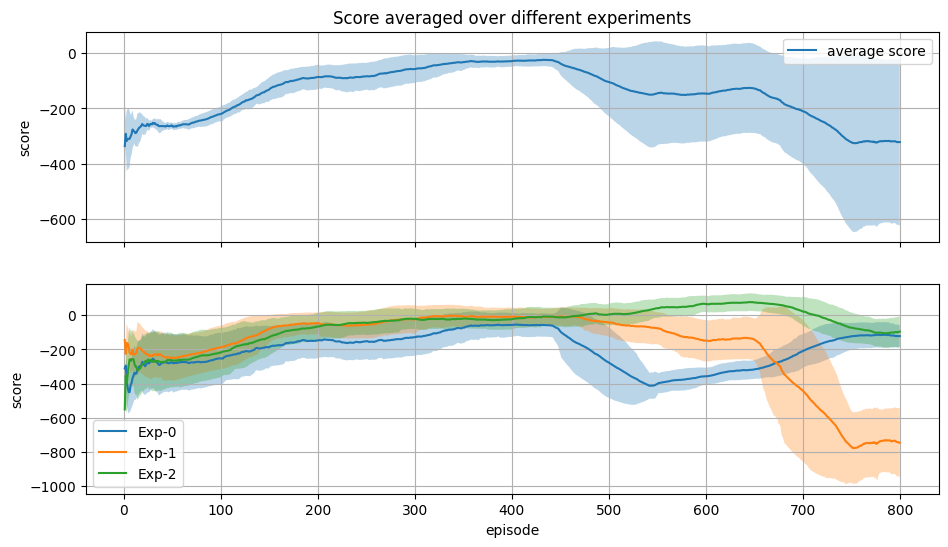

In [14]:
plot_results(avg_scores, std_scores)

We see that in the continuous case, the Actor-Critic algorithm performs worse than in the discrete case. However, it still manages to converge, although with high variance. The best mean score the algorithm receives is around 0, which is far from the 200 points of a solved environment.

Although there is not much room for comparison between the two environments, it is still nice to plot the results side-by-side and compare.

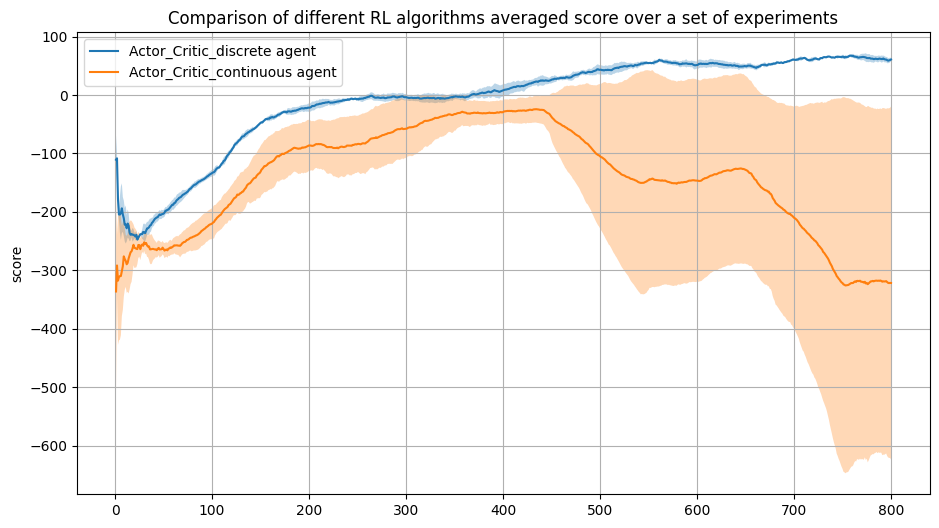

In [15]:
compare_results(results_data_dict)

## Conclusion
In the aforementioned notebook, we have seen an implementation of the *Actor-Critic TD(0)* algorithm as it were introduced in [1] (Chapter 13.5 and 13.7) for environments with discrete and continuous action spaces.
In both types of actions spaces, it seems like the algorithm is able to learn the kind of behavior needed for maximizing the return. However, I wasn't able to get it to a level of decent performance (score of 200 or higher). It is important to note that I didn't put the time and effort to tune the hyperparameters properly, which might be the reason for the low stability, and high variance in the continuous action space case. 

## References
[1] Sutton & Barto, Reinforcement Learning An Introduction -Second edition (2018)

## Contact
If you find any errors or have any comments, corrections or questions about the material presented in the notebook, please do not hesitate to contact me at elkabetz.roy@gmail.com